<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/lb1_51736_ing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, concatenate
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

## 데이터 로드

In [0]:
#submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/yeonung/test.npy').astype('float32')
#gmi_preci = np.load('/content/drive/My Drive/2020 Kaggle Study/data/gmi_preci_32bits.npy')

## 학습 데이터 선택
센서 데이터 + land type

In [0]:
x_train = train[:,:,:,:10]
y_train = train[:,:,:,14]
test = test[:,:,:,:10]
del train

## 가채점용 테스트 데이터 분리

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.025, random_state=7777)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((74436, 40, 40, 10), (74436, 40, 40), (1909, 40, 40, 10), (1909, 40, 40))

## 결측치(0보다 작은 값)가 포함된 데이터 삭제

In [6]:
y_train_ = y_train.reshape(-1,y_train.shape[1]*y_train.shape[2])
x_train = np.delete(x_train, np.where(y_train_<0)[0], axis=0)
y_train = np.delete(y_train, np.where(y_train_<0)[0], axis=0)
y_train = y_train.reshape(-1, x_train.shape[1], x_train.shape[2],1)
y_test = y_test.reshape(-1, y_test.shape[1], y_test.shape[2],1)
y_train_ = np.delete(y_train_, np.where(y_train_<0)[0], axis=0)
x_train.shape, y_train.shape

((74061, 40, 40, 10), (74061, 40, 40, 1))

## 강수량 합이 50개 이상인 데이터만 선택

In [7]:
x_train = x_train[np.sum(y_train_, axis=1) >= 50]
y_train = y_train[np.sum(y_train_, axis=1) >= 50]
x_train.shape, y_train.shape

((30594, 40, 40, 10), (30594, 40, 40, 1))

In [8]:
# Scaling

land_type_data = x_train[:,:,:,9]
land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(x_train.reshape(-1, 10))
train_scaled = train_scaled.reshape(x_train.shape)
train_scaled[:,:,:,9] = land_type_data
#train_scaled[:,:,:,-1] = gmi_preci.reshape(-1, 40, 40)  # GMI precipatation

x_train = train_scaled.astype('float16')
del train_scaled

x_train.shape

(30594, 40, 40, 10)

## 데이터 부풀리기
이미지를 회전, 반전시켜 학습 데이터 양을 8배로 부풀림

In [0]:
sample = x_train[1204,:,:,0]

In [0]:
x_train = x_train.astype('float32')

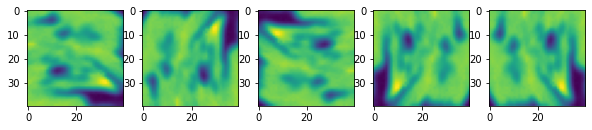

In [36]:
plt.figure(figsize=(10,20))
plt.subplot(1,5,1)
plt.imshow(sample) # 원본
plt.subplot(1,5,2)
plt.imshow(np.rot90(sample)) # 90도 
plt.subplot(1,5,3)
plt.imshow(np.rot90(np.rot90(sample))) # 180도
plt.subplot(1,5,4)
plt.imshow(np.rot90(np.rot90(np.rot90(sample)))) # 270도
plt.subplot(1,5,5)
plt.imshow(sample.T) # Transpose (이걸로 90, 180, 270도 회전 한 번 더 시행)

In [0]:
x_train = x_train.astype('float16')

In [0]:
def data_generator_half(x_train, y_train):
    rotate_X_90 = np.zeros_like(x_train)
    rotate_Y_90 = np.zeros_like(y_train)

    for j in range(rotate_X_90.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])

        rotate_X_90[j,:,:,:] = rotate_x
        rotate_Y_90[j,:,:,:] = rotate_y

    rotate_X_180 = np.zeros_like(x_train)
    rotate_Y_180 = np.zeros_like(y_train)

    for j in range(rotate_X_180.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_180[j,:,:,:] = rotate_x
        rotate_Y_180[j,:,:,:] = rotate_y

    rotate_X_270 = np.zeros_like(x_train)
    rotate_Y_270 = np.zeros_like(y_train)

    #for j in range(rotate_X_270.shape[0]):
    #    rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
    #    rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
    #    for i in range(10):
    #        rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
    #        rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
    #        rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
    #    rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
    #    rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])
    #    rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

    #    rotate_X_270[j,:,:,:] = rotate_x
    #    rotate_Y_270[j,:,:,:] = rotate_y

    x_train = np.concatenate((x_train, rotate_X_90, rotate_X_180), axis = 0)
    y_train = np.concatenate((y_train, rotate_Y_90, rotate_Y_180), axis = 0)
    del rotate_X_90, rotate_X_180

    return x_train, y_train

In [0]:
def data_generator(x_train, y_train):
    rotate_X_90 = np.zeros_like(x_train)
    rotate_Y_90 = np.zeros_like(y_train)

    for j in range(rotate_X_90.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])

        rotate_X_90[j,:,:,:] = rotate_x
        rotate_Y_90[j,:,:,:] = rotate_y

    rotate_X_180 = np.zeros_like(x_train)
    rotate_Y_180 = np.zeros_like(y_train)

    for j in range(rotate_X_180.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_180[j,:,:,:] = rotate_x
        rotate_Y_180[j,:,:,:] = rotate_y

    rotate_X_270 = np.zeros_like(x_train)
    rotate_Y_270 = np.zeros_like(y_train)

    for j in range(rotate_X_270.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_270[j,:,:,:] = rotate_x
        rotate_Y_270[j,:,:,:] = rotate_y

    x_train = np.concatenate((x_train, rotate_X_90, rotate_X_180, rotate_X_270), axis = 0)
    y_train = np.concatenate((y_train, rotate_Y_90, rotate_Y_180, rotate_Y_270), axis = 0)
    del rotate_X_90, rotate_X_180, rotate_X_270

    x_T = np.zeros_like(x_train)
    y_T = np.zeros_like(y_train)

    for i in range(x_train.shape[0]):
        for j in range(x_train.shape[3]):
            x_T[i,:,:,j] = x_train[i,:,:,j].T
        y_T[i,:,:,0] = y_train[i,:,:,0].T

    x_train = np.concatenate((x_train, x_T), axis = 0)
    y_train = np.concatenate((y_train, y_T), axis = 0)

    del x_T,y_T
    
    return x_train, y_train

In [70]:
x_tmp = np.random.randn(100, 40, 40, 10)
y_tmp = np.random.randn(100, 40, 40, 1)
x_tmp, y_tmp = data_generator_half(x_tmp, y_tmp)
x_tmp.shape, y_tmp.shape

((300, 40, 40, 10), (300, 40, 40, 1))

## 평가 함수 정의

In [0]:
def mae_over_fscore(y_true, y_pred):
    '''
    y_true: sample_submission.csv 형태의 실제 값
    y_pred: sample_submission.csv 형태의 예측 값
    '''
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]

    # 실제값이 0.1 이상인 픽셀의 위치 확인
    IsGreaterThanEqualTo_PointOne = y_true >= 0.1
    
    # 실제 값에 결측값이 없는 픽셀의 위치 확인 
    IsNotMissing = y_true >= 0
    
    # mae 계산
    mae = np.mean(np.abs(y_true[IsGreaterThanEqualTo_PointOne] - y_pred[IsGreaterThanEqualTo_PointOne]))
    
    # f1_score 계산 위해, 실제값에 결측값이 없는 픽셀에 대해 1과 0으로 값 변환
    y_true = np.where(y_true[IsNotMissing] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[IsNotMissing] >= 0.1, 1, 0)
    
    # f1_score 계산    
    f_score = f1_score(y_true, y_pred)

    # f1_score가 0일 나올 경우를 대비하여 소량의 값 (1e-07) 추가 
    return mae / (f_score + 1e-07)

## 손실 함수 정의

In [0]:
def mae(y_true, y_pred):    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

## 모델 설계 및 학습
강수량을 예측할 지점에서 멀리 있는 데이터일수록 영향이 적어져 풀링 레이어가 결과 예측에 방해가 될 것으로 판단.  
Convolution과 residual block만으로 모델 설계.

In [0]:
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
model = create_model()

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 훈련

In [53]:
train = np.concatenate([x_train, y_train], axis=3)
train.shape # 0~9채널, target

(30594, 40, 40, 11)

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    
    train_dataset = train_dataset.batch(32).prefetch(1) # batch size: 512 -> 32

    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(32).prefetch(1) # batch size: test_size -> 32

    callbacks_list = [
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=3,
                    factor=0.8
                ),

                tf.keras.callbacks.ModelCheckpoint(
                    filepath = '/content/drive/My Drive/2020 Kaggle Study/model/model_new_'+str(fold_number)+'.h5',
                    monitor='val_maeOverFscore_keras',
                    save_best_only=True
                )
            ]

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset, callbacks=callbacks_list)

    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()

## 가채점

In [0]:
preds = []
for model in models:
    preds.append(model.predict(x_test))
    print(mae_over_fscore(y_test, preds[-1]))

pred = sum(preds)/len(preds)
print('합산 예측 점수:', mae_over_fscore(y_test, pred))

## Submission

In [0]:
submission.iloc[:,1:] = pred.reshape(-1,1600)
submission

In [0]:
submission.to_csv('/content/drive/My Drive/2020 Kaggle Study/submission/submission.csv', index=False)